# Análise Exploratória dos Dados - Competição "Talking Data"
## Alunos: Alessandro Rivello e Raul Guarini

Fazemos uma análise dos dados de teste e treinamento neste notebook. No caso do dados de treinamento, trabalhamos com uma amostra de 10% dos dados originais, frente ao tamanho do arquivo train.csv (quase 190 milhões de linhas!!!!!). O algoritmo para escolha da amostra está disponível no script ```row_select.py```.

Ambos datasets continham a coluna "click_time" com o timestamp do acesso no formato "YYYY-MM-DD hh:mm:ss". Para poder trabalhar os dados, utilizamos o comando ```sed``` no Terminal para:
1. Eliminar informação sobre o ano e o mês, em vista do fato de que todos os dados se encontram numa janela de apenas quatro dias. Isto torna o dataset mais leve e mais fácil de ser manipulado;
2. Colocar as colunas de dias, horas, minutos e segundos separadamente, facilitando também a análise.

No caso dos dados de teste, por exemplo, o comando utilizado foi: 
```
cat test.csv | sed 's/2017-11-//g' | sed -E -e 's/[[:space:]]/,/g' -e 's/:/,/g' -e 's/click_time/days,hours,minutes,seconds/g' > test_timed.csv

```

Também julgamos desnecessária a coluna "attributed_time". É um timestamp do horário em que o download foi feito. Como veremos, ela aporta pouca informação pois o dataset é amplamente desbalanceado, com poucos downloads efetivos. Além disso, este dado é gerado após o download ser feito, o que o torna incompatível com a tarefa de prever se o download ocorrerá ou não. Portanto, os dados utilizados estão disponíveis nos arquivos ```10_train_timed.csv``` e ```test_timed.csv```.

Links do Dropbox para estes arquivos (zipados):
1. ```10_train_timed.csv```: https://www.dropbox.com/s/d16l70ib5y0tjyr/10_train_timed.csv.zip?dl=0
2. ```test_timed.csv```: https://www.dropbox.com/s/gg14d21zskkqg7r/test_timed.csv.zip?dl=0

### Importando os dados

In [4]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import datetime

# Definindo o estilo dos plots
sns.set_style("darkgrid")
sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Mudar o path conforme necessário
path_raul = '/Users/Raul/Desktop/'

In [5]:
# Definir os datatypes antes da importação otimiza o uso de memória pelo Pandas.
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [6]:
# Forçando o Pandas a ler as mesmas colunas, sem necessidade de ler click_time e nem click_id 
# na análise exploratória.
cols_train = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes', 'seconds']
cols_test = ['ip', 'app', 'device', 'os', 'channel', 'days', 'hours', 'minutes', 'seconds']

train = pd.read_csv(path_raul + '10_train_timed.csv', dtype = dtypes, usecols = cols_train)
test = pd.read_csv(path_raul + 'test_timed.csv', dtype = dtypes, usecols = cols_test)

In [7]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,114221,3,1,19,379,0,6,14,37,59
2,47902,3,1,17,379,0,6,14,48,7
3,23550,3,1,13,379,0,6,14,53,39
4,84644,3,1,19,379,0,6,14,56,49


In [8]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18490388 entries, 0 to 18490387
Data columns (total 10 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint8
days             uint8
hours            uint8
minutes          uint8
seconds          uint8
dtypes: uint16(4), uint32(1), uint8(5)
memory usage: 299.8 MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 9 columns):
ip         uint32
app        uint16
device     uint16
os         uint16
channel    uint16
days       uint8
hours      uint8
minutes    uint8
seconds    uint8
dtypes: uint16(4), uint32(1), uint8(4)
memory usage: 286.7 MB


### Valores Únicos

/Users/Raul/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


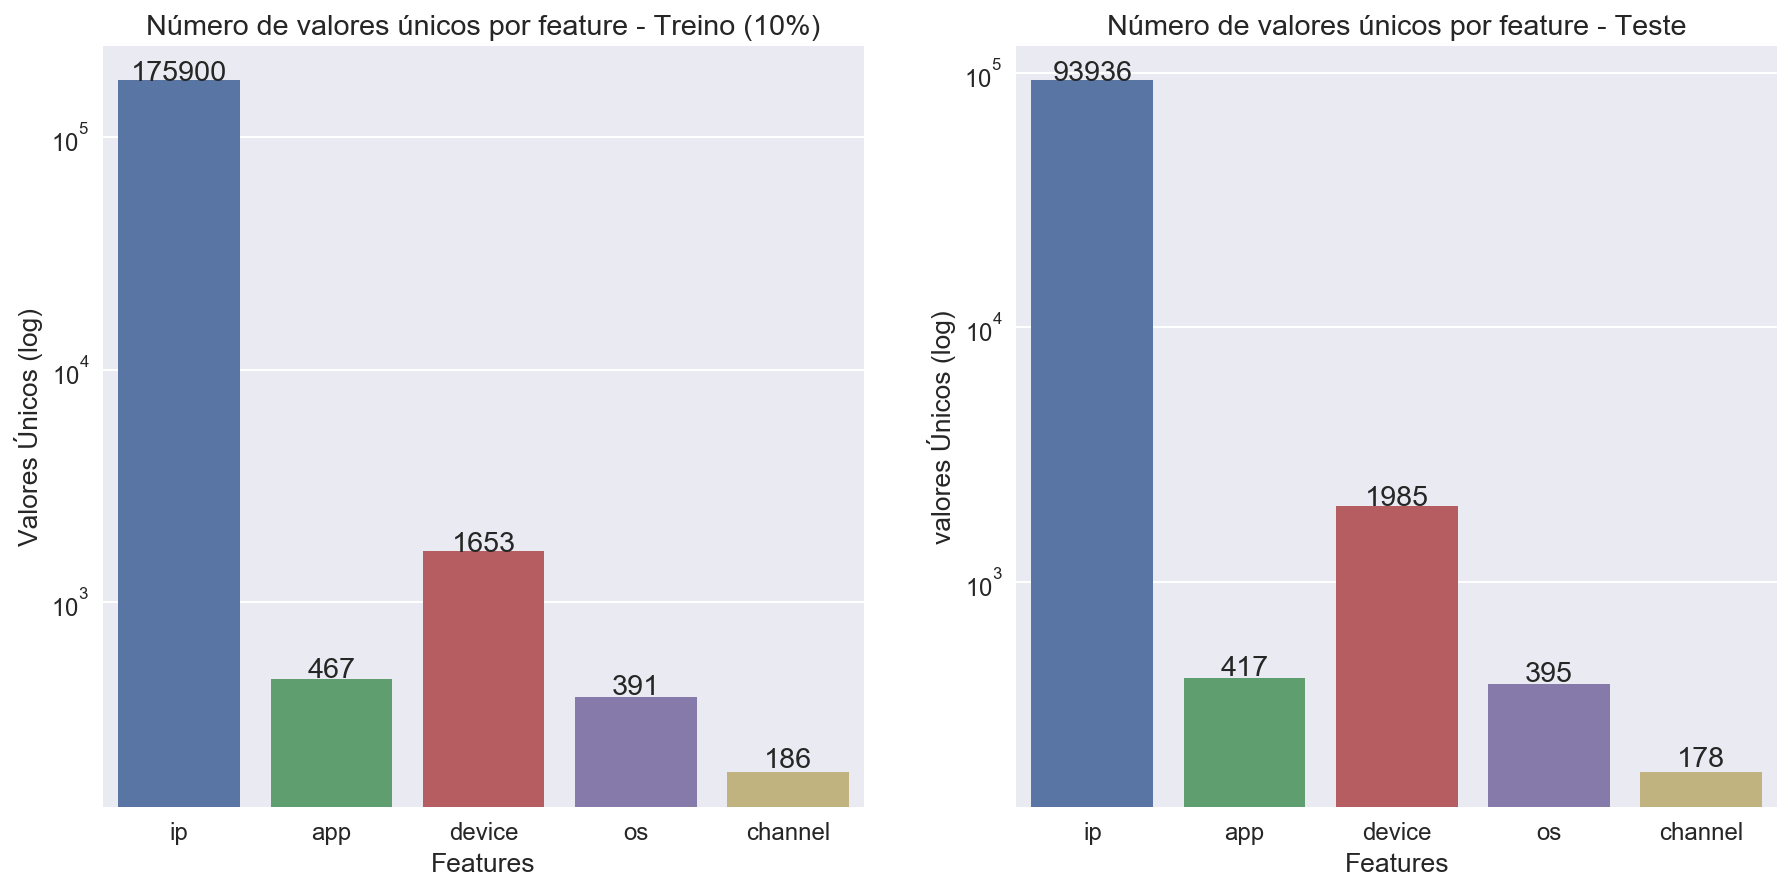

In [11]:
plt.figure(figsize=(10,6));
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques_train = [len(train[col].unique()) for col in cols]
uniques_test = [len(test[col].unique()) for col in cols]

sns.set(font_scale=1.2)

fig, axs = plt.subplots(1, 2,figsize=(15,7));
graph_train = sns.barplot(cols, uniques_train, ax=axs[0], log=True);
graph_test = sns.barplot(cols, uniques_test, ax=axs[1], log=True);

graph_train.set(xlabel='Features', ylabel='Valores Únicos (log)', title='Número de valores únicos por feature - Treino (10%)');
graph_test.set(xlabel='Features', ylabel='valores Únicos (log)', title='Número de valores únicos por feature - Teste');

for t, tt, uniq_t, uniq_tt in zip(graph_train.patches, graph_test.patches, uniques_train, uniques_test):
    height_train=t.get_height()
    height_test=tt.get_height()
    graph_train.text(t.get_x()+t.get_width()/2.,
            height_train + 10,
            uniq_t,
            ha="center");
    graph_test.text(tt.get_x()+tt.get_width()/2.,
            height_test + 10,
            uniq_tt,
            ha="center");

Como esperado, o número de registros únicos é muito maior entre IPs do que entre as outras *features*. Vemos este resultado como natural uma vez que um aplicativo muito popular pode ser baixado milhares de vezes. É fácil conceber que possam existir diferentes peças de hardware com o mesmo OS e assim por diante.

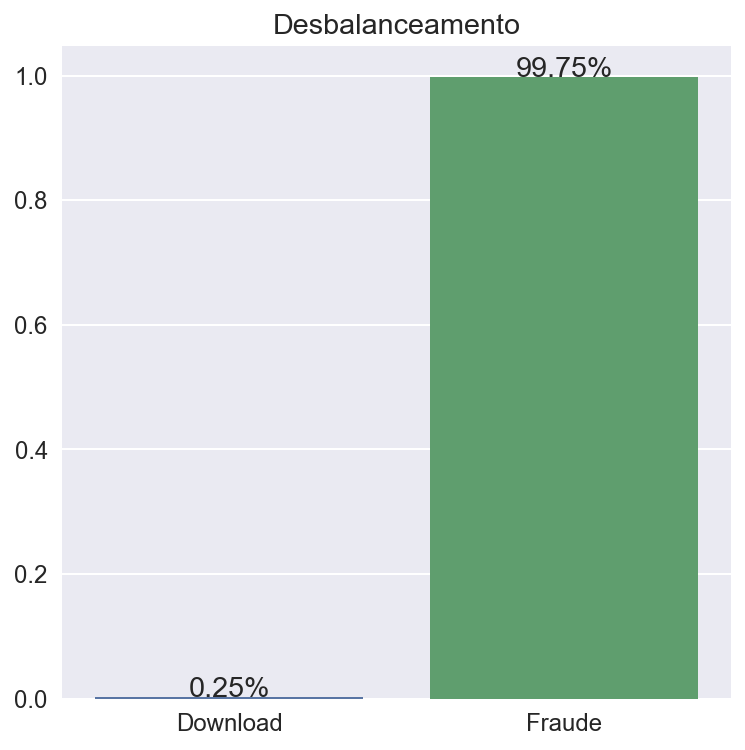

In [12]:
# Há muitas fraudes nos dados de treino?

plt.figure(figsize=(6,6))
downl = (train.is_attributed.values == 1).mean()
ndownl = 1 - downl
downloads = [downl, ndownl]
cols = ['Download', 'Fraude']

ax = sns.barplot(cols, downloads)
ax.set(title='Desbalanceamento')

for c, d in zip(ax.patches, downloads):
    height=c.get_height()
    ax.text(c.get_x()+c.get_width()/2.,
            height,
            '{}%'.format(round(d*100,2)),
            ha="center")

O gráfico acima acende a luz da preocupação. Aproximadamente apenas 1 click a cada 400 se converte em download!!! Isto deixa margem para acreditarmos que algum tipo de fraude esteja ocorrendo. Este detalhe pode representar um desafio quando estivermos trabalhando, no futuro, com um modelo preditivo.

### Tempo
Vamos utilizar dados de timestamp primeiramente para entender o aspecto temporal. O quão dispersos ao longo dos dias são os cliques?

In [13]:
day_hour_train = train[['days', 'hours']].drop_duplicates().groupby('days').count()
day_hour_test = test[['days', 'hours']].drop_duplicates().groupby('days').count()

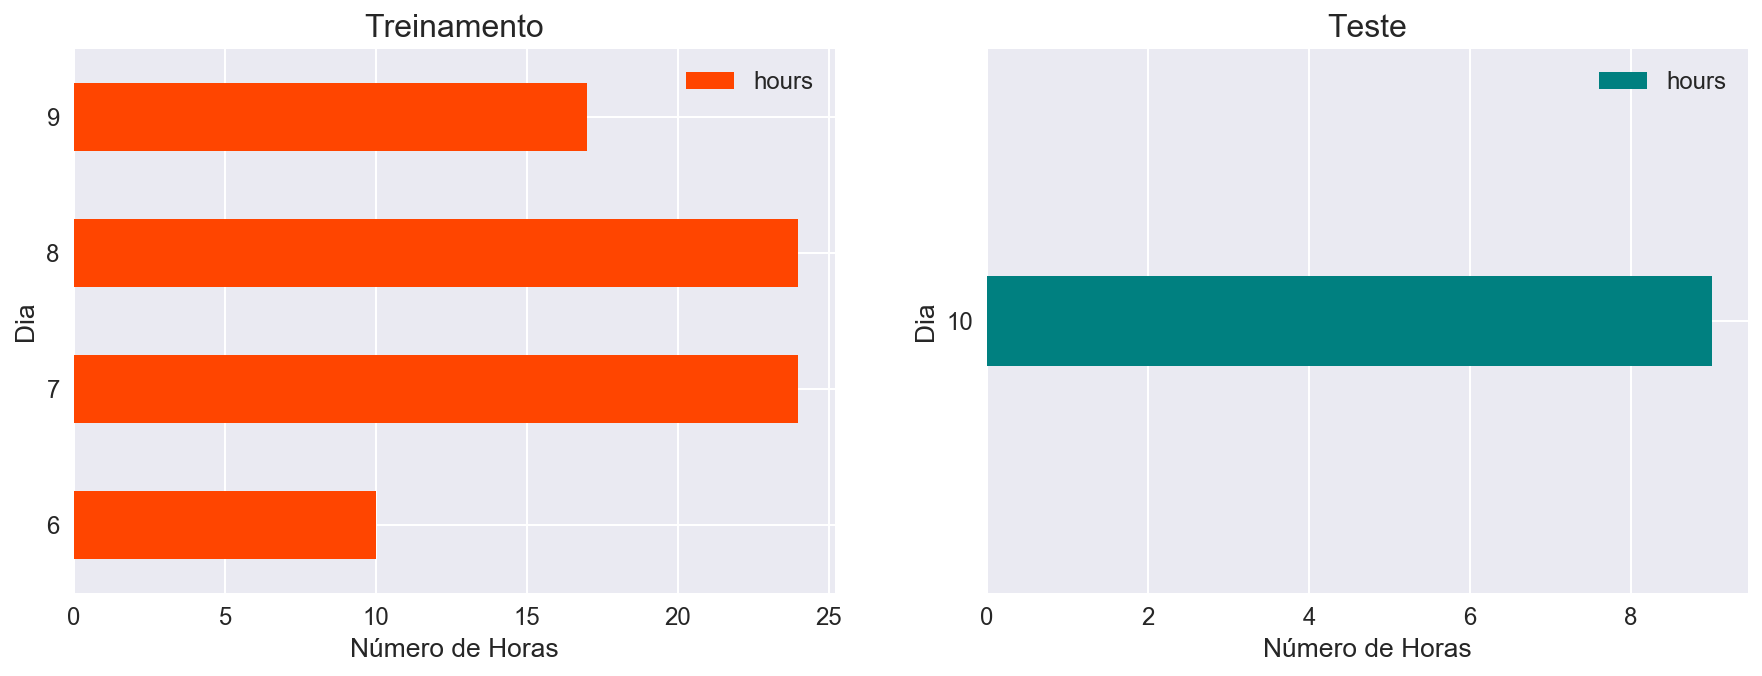

In [14]:
# Plotando os resultados acima
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
day_hour_train.plot(kind = 'barh', ax = axs[0], title = 'Treinamento', 
                    color = 'orangered', width=0.5);
day_hour_test.plot(kind = 'barh', ax = axs[1], title = 'Teste', 
                   color = 'teal', width=0.1);

axs[0].set_xlabel('Número de Horas');
axs[0].set_ylabel('Dia');
axs[0].title.set_size(16)

axs[1].set_xlabel('Número de Horas');
axs[1].set_ylabel('Dia');
axs[1].title.set_size(16)

sns.despine()

Vemos que os dados de treinamento compreendem os dias 6,7,8 e 9, ao passo que os dados de teste são somente do dia 10. Para os dias 7 e 8, temos observações em todas as horas. Para os dados de teste, temos observações em apenas 9 horas ao longo do dia. A próxima pergunta é: como se distribuem os clicks ao longo do dia?

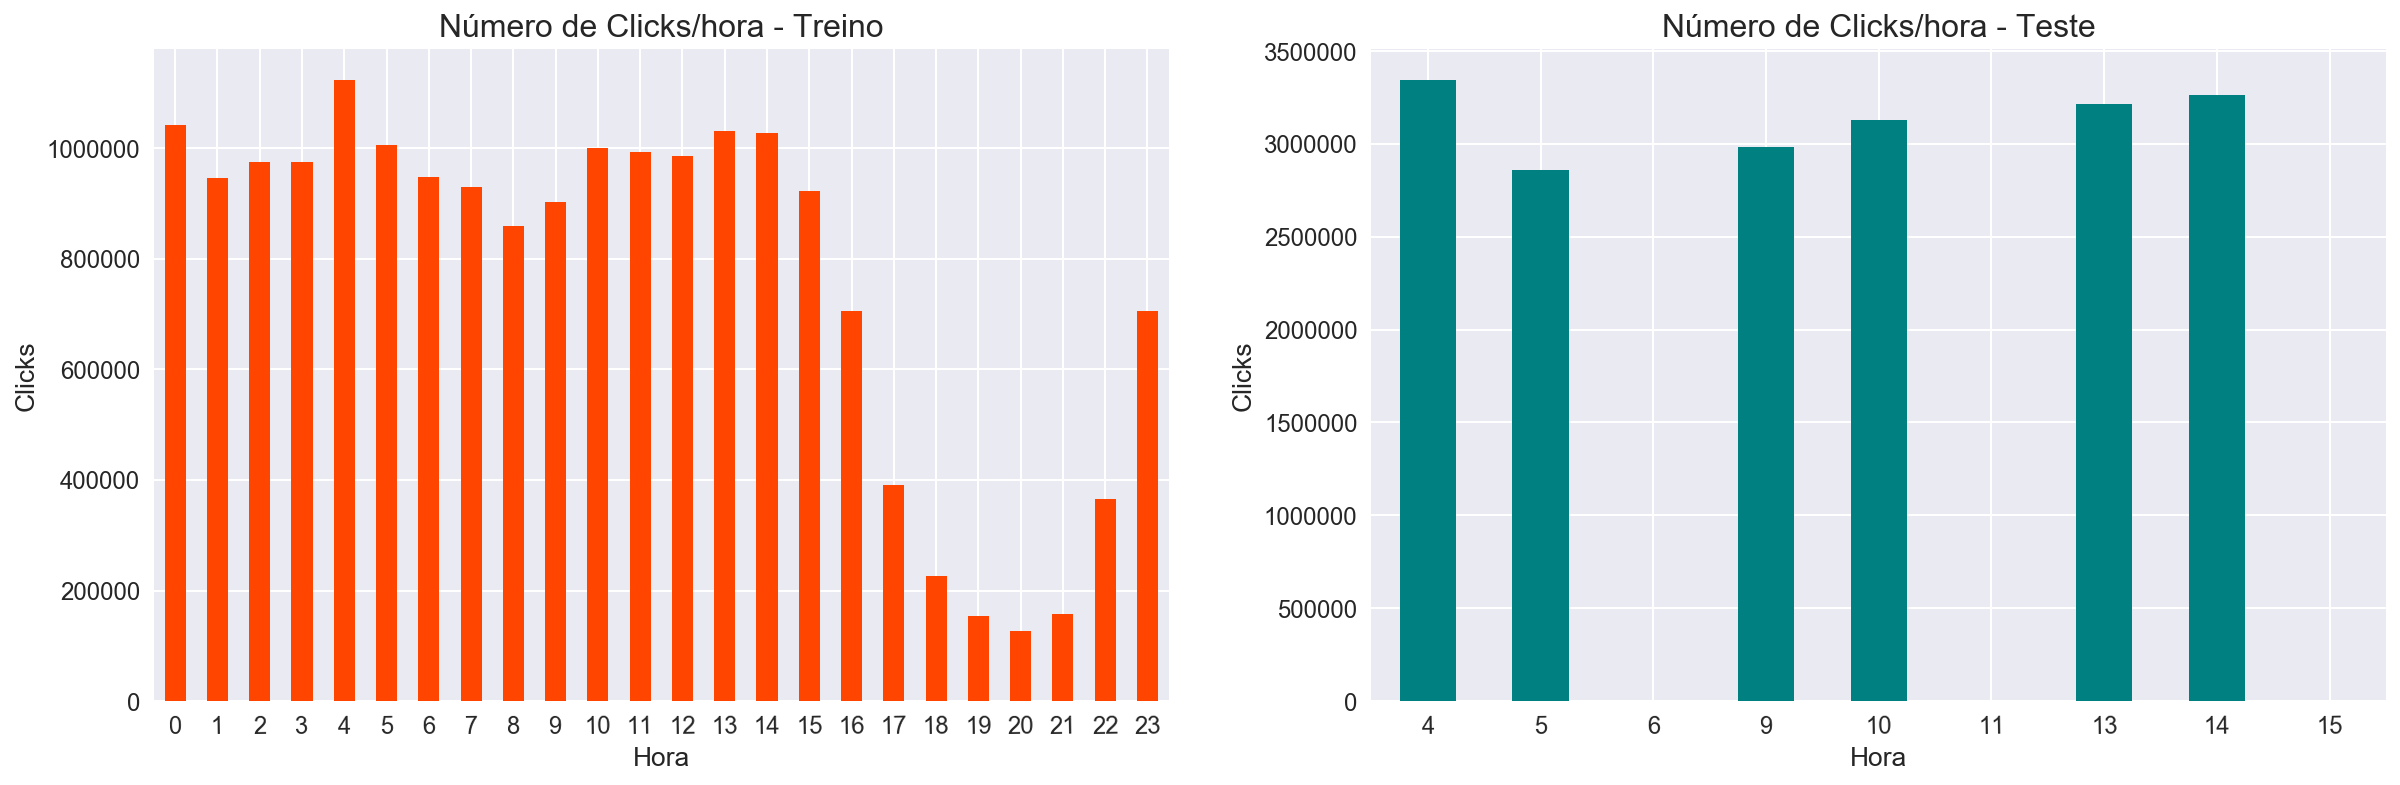

In [15]:
# Plotando número a dispersão de clicks ao longo do dia
fig, axs = plt.subplots(1,2, figsize = (20,6))

# Para os dados de treinamento:
train['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[0], color = 'orangered',
                title = 'Número de Clicks/hora - Treino');
axs[0].set_xlabel('Hora');
axs[0].set_ylabel('Clicks');
axs[0].tick_params(axis = 'x', labelrotation = 1)
axs[0].title.set_size(16)

#Para os dados de teste:
test['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[1], color = 'teal',
                title = 'Número de Clicks/hora - Teste');
axs[1].set_xlabel('Hora');
axs[1].set_ylabel('Clicks');
axs[1].tick_params(axis = 'x', labelrotation = 1)
axs[1].title.set_size(16)

In [16]:
test['hours'].value_counts(sort = False)

4     3344125
5     2858427
6         381
9     2984808
10    3127993
11        413
13    3212566
14    3261257
15        499
Name: hours, dtype: int64

Nos dados de treino, observamos que a maior parte dos clicks ocorreu do início da madrugada até o fim da tarde. A partir das 16hs, vemos um clara queda no número de cliques, potencialmente o momento em que as pessoas estavam indo de volta para casa ou indo dormir. Enfatizamos que os dias representados nos dados foram dias úteis, ao longo de uma mesma semana em Novembro de 2017. Curiosamente, após as 22hs, o número de cliques volta a subir.

No caso dos dados de teste, não há um padrão claro. Podemos identificar, contudo, que não há um número de cliques expressivos identificados nos dados às 6hs, 11hs e 15hs. Esta afirmação é confirmada pela simples contagem de cliques por hora feita acima. Como visto no gráfico anterior, os dados de teste são mais concentrados em alguns momentos ao longo do dia se comparados aos dados de treinamento.

Frente ao desbalanceamento do dataset, a pergunta seguinte é: quantos desses clicks são convertidos efetivamente em downloads, no caso dos dados de treinamento?

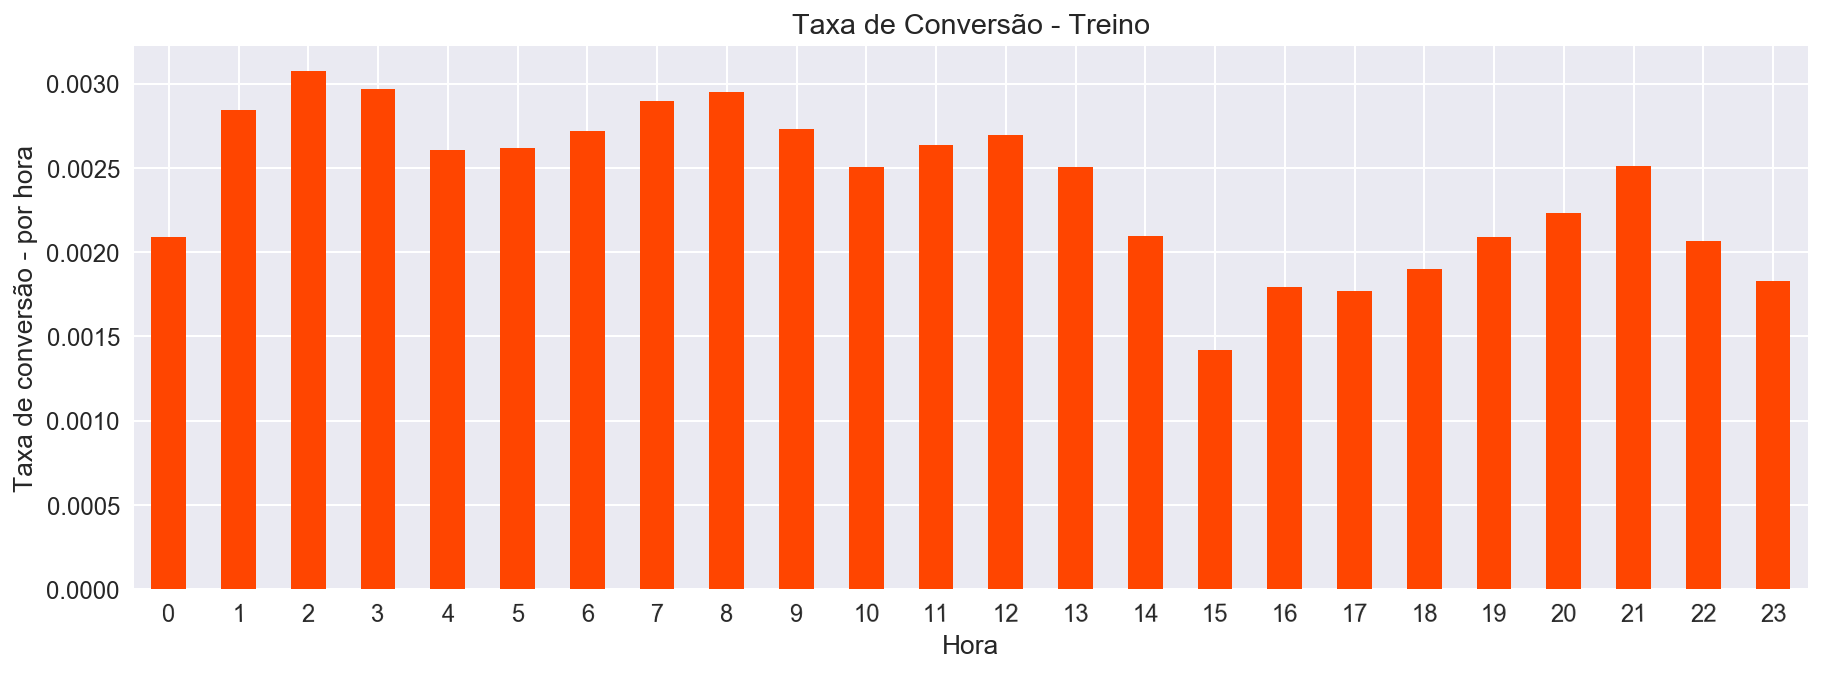

In [17]:
# Plotando a taxa de conversão dos cliques em download a cada hora
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
train[['hours', 'is_attributed']].groupby('hours').agg(np.mean).plot(kind = 'bar', color = 'orangered', 
                                                                   title = 'Taxa de Conversão - Treino', legend = None, ax = ax);
ax.set_xlabel('Hora');
ax.set_ylabel('Taxa de conversão - por hora')
ax.tick_params(axis = 'x', labelrotation = 1)

Notamos que a taxa de conversão ao longo do dia é consistentemente menor que 0.3%! Isto quer dizer que poucos downloads são, de fato, realizados e temos vários clicks em vão. As maiores taxas de conversão são encontradas durante a madrugada, enquanto as menores no meio da tarde.

Será que existe alguma tendência ao longo dos *dias*?

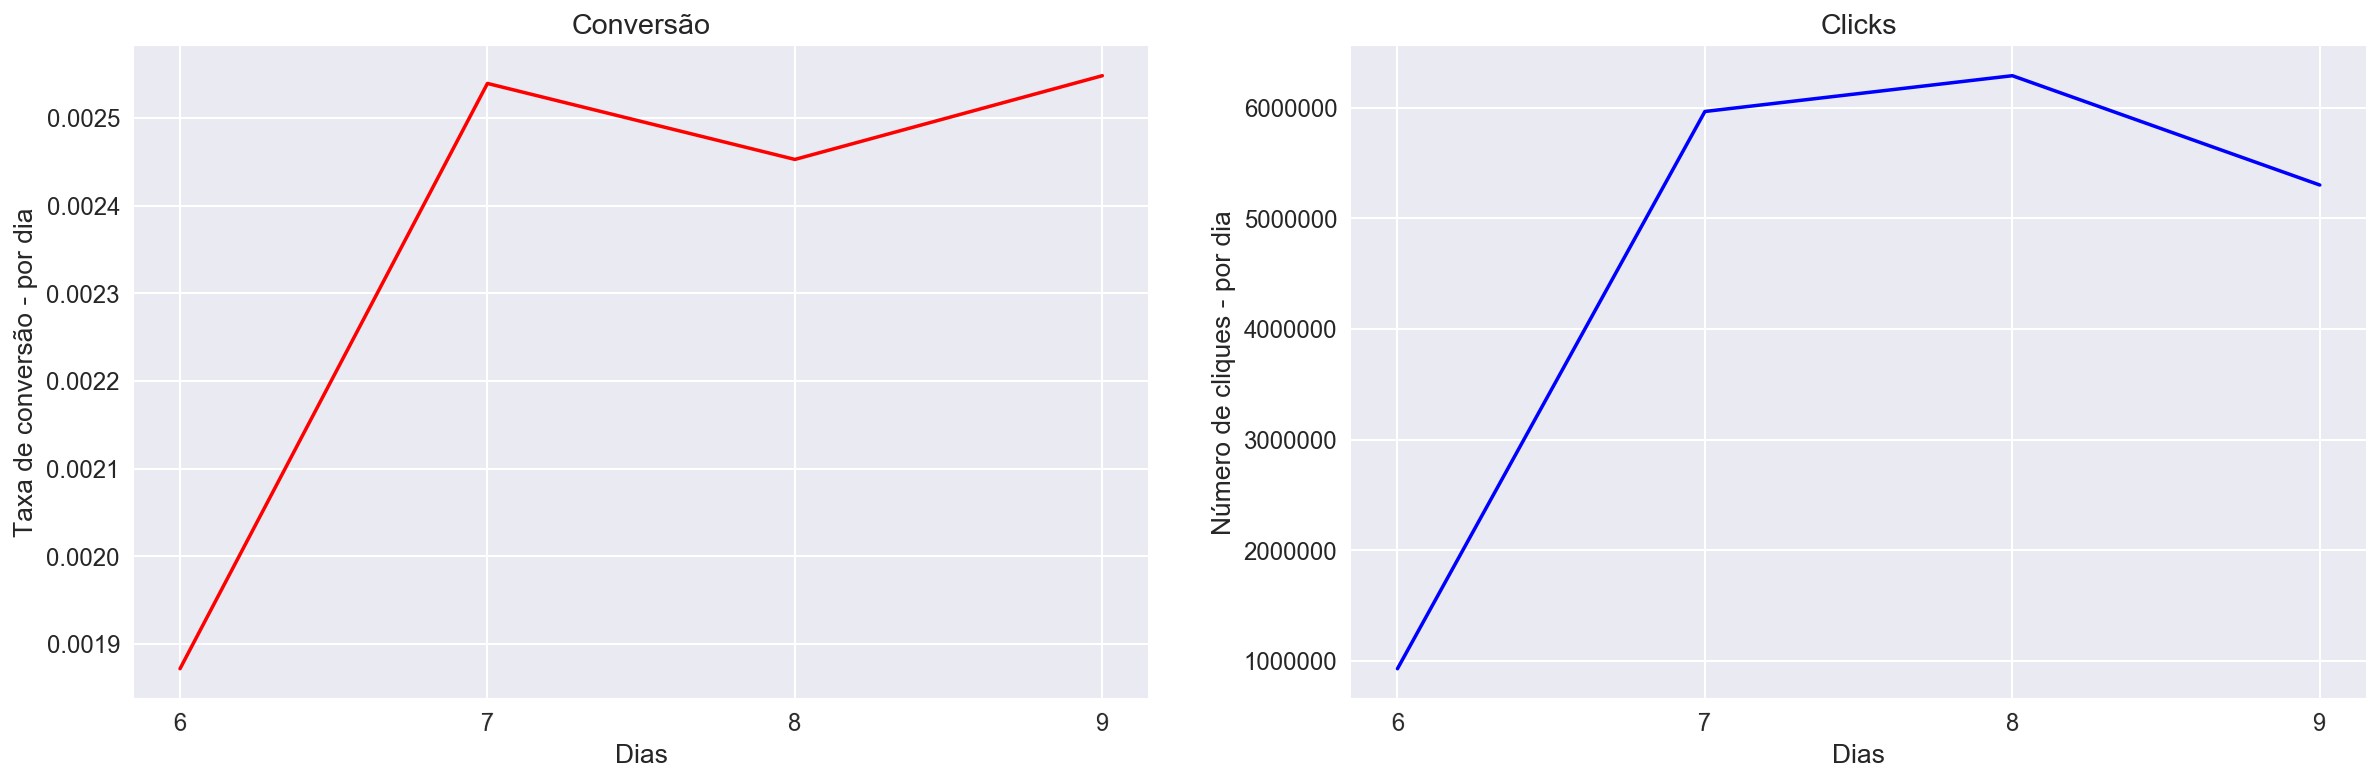

In [18]:
# Buscando uma tendência temporal para a taxa de convesão e número de clicks nos dados de treinamento
fig, axs = plt.subplots(1,2, figsize = (20,6))
df = train[['days', 'is_attributed']].groupby('days').agg([np.mean, 'count'])
df.reset_index()
df['is_attributed']['mean'].plot(kind = 'line', color = 'red', ax = axs[0], title = 'Conversão', legend = None,
                                xticks = [6,7,8,9]);
df['is_attributed']['count'].plot(kind = 'line', color = 'blue', ax = axs[1], title = 'Clicks', legend = None,
                                 xticks = [6,7,8,9]);

axs[0].tick_params(axis = 'x', labelrotation = 1);
axs[0].set_ylabel('Taxa de conversão - por dia');
axs[0].set_xlabel('Dias');

axs[1].tick_params(axis = 'x', labelrotation = 1);
axs[1].set_ylabel('Número de cliques - por dia');
axs[1].set_xlabel('Dias');

Não há nenhum tipo de tendência visível ao longo dos quatro dias nos dados de treinamento. Podemos notar apenas que há muito menos dados para o dia 6 e que a taxa de conversão também foi menor neste dia.

Vamos analisar se o fluxo de clicks subsequentes na rede é similar para o caso em que há downloads e em que não há.

In [19]:
# Esta funcao calcula uma serie de diferenças de timestamp para cada classe
def total_dif(dataframe, download):
    cols_list = ['ip','is_attributed', 'days', 'hours', 'minutes', 'seconds']
    df = (dataframe[cols_list][dataframe['is_attributed'] == download]).sort_values(by = ['days', 'hours', 'minutes', 'seconds'])
    df['min_dif'] = df['minutes'] - df['minutes'].shift(1)
    df['hour_dif'] = df['hours'] - df['hours'].shift(1)
    df['s_dif'] = df['seconds'] - df['seconds'].shift(1)
    df['day_dif'] = df['days'] - df['days'].shift(1)
    df['total_dif'] = df['day_dif']*24*3600 + df['hour_dif']*3600 + df['min_dif']*60 + df['s_dif']
    series = df['total_dif']
    del df
    return series

In [20]:
# Computando as diferenças de timestamp
train['total_dif_1'] = total_dif(train, 1)
train['total_dif_0'] = total_dif(train, 0)

In [21]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,total_dif_1,total_dif_0
0,103022,3,1,23,379,0,6,14,37,44,NaN,NaN
1,114221,3,1,19,379,0,6,14,37,59,NaN,15.0
2,47902,3,1,17,379,0,6,14,48,7,NaN,608.0
3,23550,3,1,13,379,0,6,14,53,39,NaN,332.0
4,84644,3,1,19,379,0,6,14,56,49,NaN,190.0


In [22]:
# Analisando graficamente com Bokeh
from bokeh.plotting import figure, output_file, show, output_notebook

p = figure(plot_width = 800, plot_height = 500, title = 'Densidade/Esparsidade dos clicks',
          x_axis_label = 'Ordenamento Cronológico dos clicks', y_axis_label = 'Diferença de timestamps (segundos)', 
           y_range=(0,250))

x1 = train['total_dif_1'][train['total_dif_1'].notnull()].index
y1 = train['total_dif_1'][train['total_dif_1'].notnull()].values

# Nao plotamos todos os elementos da serie de fraudes pois o kernel do jupyter começar a reclamar por conta da memória!
x0 = train['total_dif_0'][train['total_dif_0'].notnull()].index[1:-1:40000]
y0 = train['total_dif_0'][train['total_dif_0'].notnull()].values[1:-1:40000]

p.circle(x = x1, y = y1, size = 3, color = 'blue', alpha = 0.3, legend = 'Downloads')
p.circle(x = x0, y = y0, size = 5, color = 'red', alpha = 0.9, legend = 'Fraudes')

output_notebook()

# Aproveite as opções de zoom do Bokeh para analisar este gráfico!!!
show(p)

Loading BokehJS ...

O gráfico acima é alarmante. Nele, podemos ver duas características inesperadas dos dados:
1. Os cliques classificados como fraudulentos ocorrem em alta frequência, isto é, há uma diferença negligenciável entre os timestamps de clicks fraudulentos consecutivos. Este tipo de comportamento dá força à hipótese de existência de bots criando clicks que não levam a downloads. Por outro lado, os downloads são muito mais espaçados, ou seja, ocorrem em menor frequência. Esta observação sugere que um modelo preditivo deveria levar em conta não somente o momento do click atual mas, se possível, também o tempo decorrido desde o último click.
2. Há uma periodicidade no caso dos downloads. A diferença de timestamp entre downloads consecutivos é estável na maior parte do tempo, de no máximo 20 segundos. Contudo, há *spikes* nos dados: momentos em que a diferença de tempo entre downloads consecutivos torna-se maior e parece que estes *spikes* ocorrem periodicamente.

O comportamento periódico talvez seja melhor entendido se olharmos para os downloads que mais "se atrasaram":

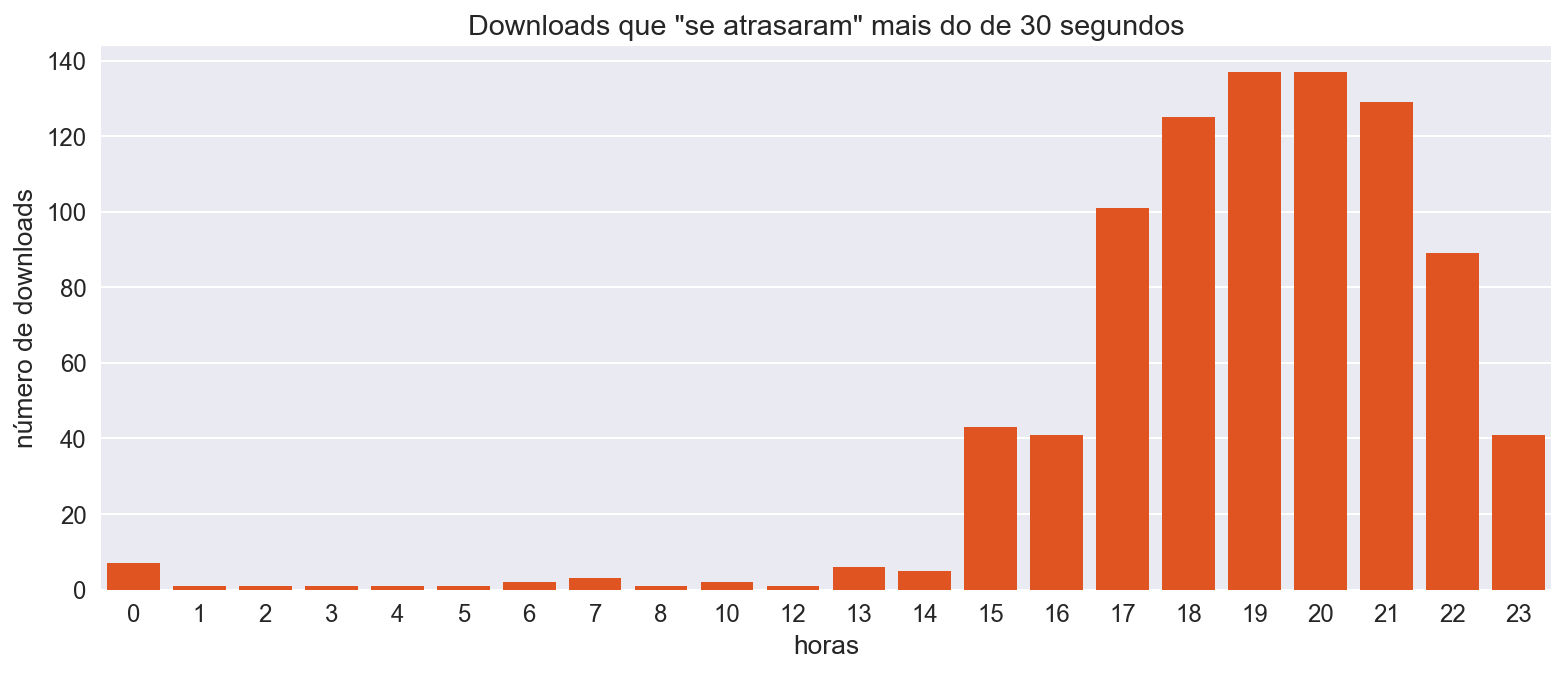

In [23]:
limit = 30;
lazy_ones = train[train['total_dif_1'] > limit][['total_dif_1', 'hours']].groupby('hours').agg('count')
lazy_ones.index.name = 'horas'
lazy_ones.columns = ['número de downloads']
fig, axs = plt.subplots(figsize = (13,5))
sns.barplot(x = lazy_ones.index, y = 'número de downloads', data = lazy_ones, hue = None, color = 'orangered',
                 ax = axs);
axs.set_title('Downloads que "se atrasaram" mais do de ' + str(limit) + ' segundos');

Considerando, por exemplo, apenas os downloads que demoraram mais do que 30 segundos para serem requisitados desde o último download registrado, vemos que há um desbalanceamento: eles ocorrem muito mais frequentemente entre o início da tarde e meia-noite. Isto explica o padrão cíclico visto de Densidade/Esparsidade dos clicks.

É curioso notar que este período coincide com o período de menor número de clicks, já indicado num gráfico anterior.

In [24]:
# Otimizando memória
del train['total_dif_1']
del train['total_dif_0']
gc.collect();

### IP's
Vejamos agora a relação entre clicks e IPs. Já sabemos que pouco mais de 175,000 IPs são responsáveis por todos os clicks gerados. Mas estariam estes clicks distribuídos uniformemente entre os IPs?

In [25]:
# Vamos contar quantos clicks, downloads e qual a taxa de conversão de cada IP
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', 
                                                                                             ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', 
                                                                                          ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'clicks', 'prop']
merge['downloads'] = merge['clicks']*merge['prop']

merge.head()

,ip,clicks,prop,downloads
0,5348,123470,0.001855,229.0
1,5314,117347,0.001934,227.0
2,73516,77004,0.001467,113.0
3,73487,76840,0.001510,116.0
4,53454,49921,0.000300,15.0


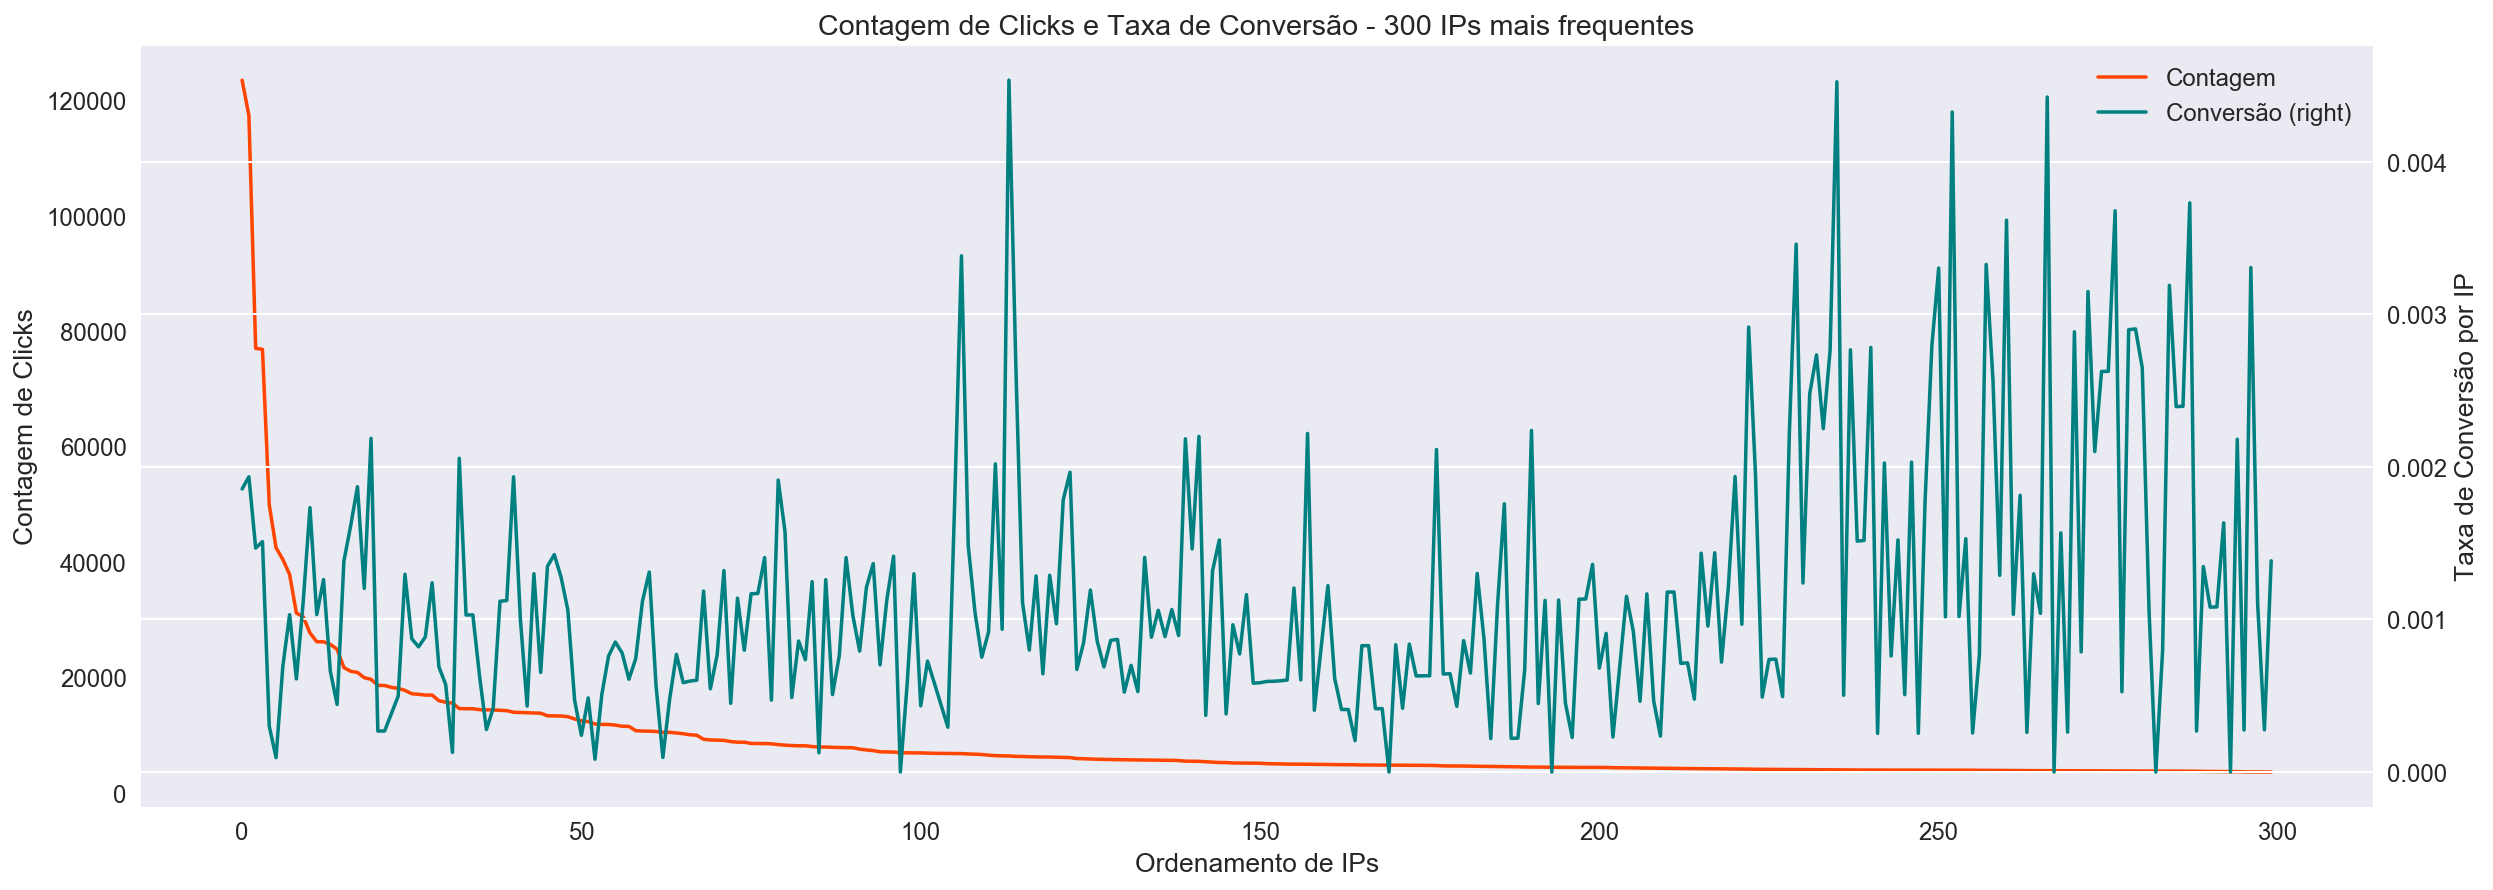

In [26]:
# Plotando o número de clicks e a proporção de downloads (Taxa de Conversão por IP)
limit = 300
ax1 = merge.clicks[:limit].plot(figsize = (20,7), color = 'orangered', legend = True, label = 'Contagem')
ax2 = merge.prop[:limit].plot(color = 'teal', secondary_y = True, legend = True, label = 'Conversão')
ax1.set(title = 'Contagem de Clicks e Taxa de Conversão - ' + str(limit) + ' IPs mais frequentes', 
        xlabel = 'Ordenamento de IPs', ylabel = 'Contagem de Clicks');
ax2.set(ylabel = 'Taxa de Conversão por IP');

Fica claro que alguns IPs são responsáveis por um tráfego desproporcionalmente grande na rede, gerando muitos registros. Entretanto, isto não está diretamente relacionado a uma alta taxa de conversão. Ao contrário, a taxa de conversão parece maior na extrema direita do gráfico. Uma outra visualização pode ser feita com o gráfico abaixo:

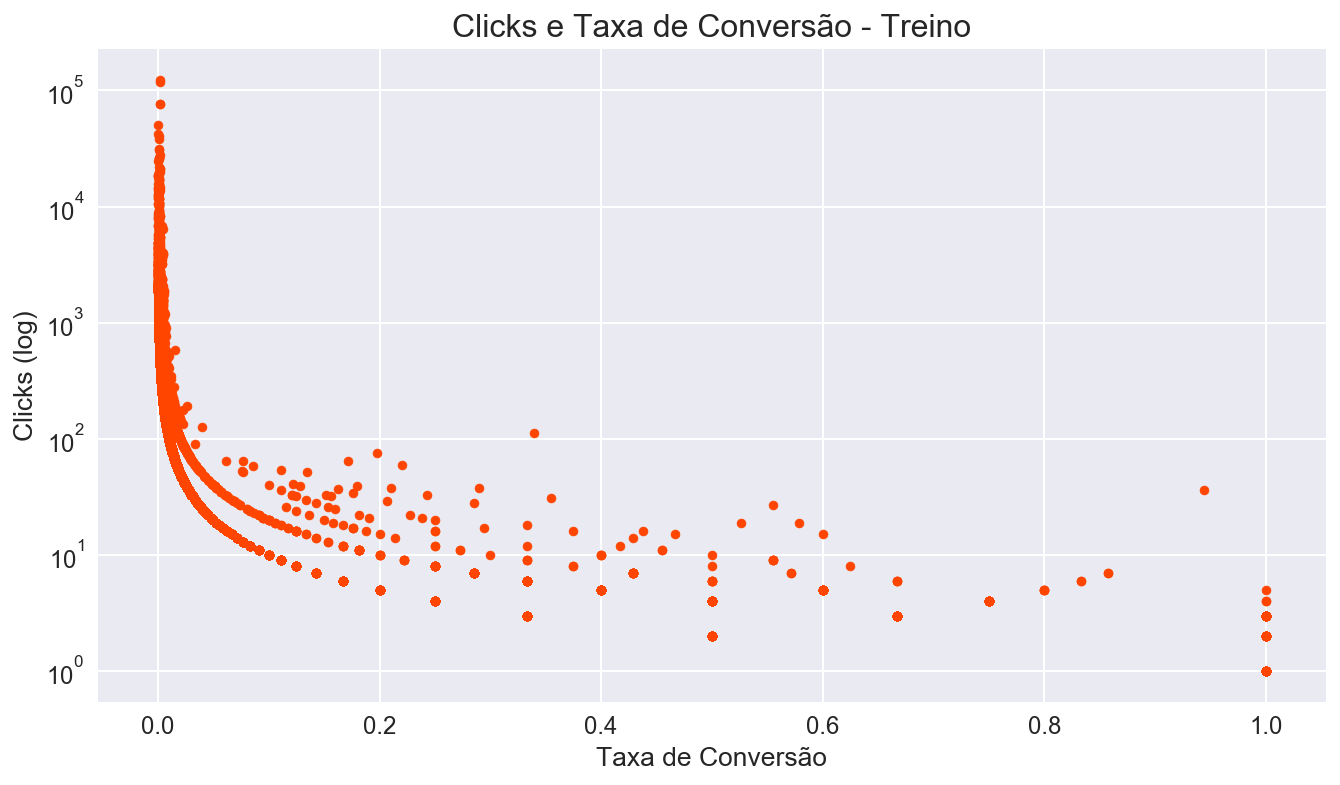

In [27]:
fig = merge[merge['prop'] > 0].plot(kind = 'scatter', x = 'prop', y = 'clicks', color = 'orangered', figsize = (11,6), 
                        logy = True)

fig.set_ylabel('Clicks (log)');
fig.set_xlabel('Taxa de Conversão');
fig.set_title('Clicks e Taxa de Conversão - Treino', fontsize=16);

A visualização acima não deixa dúvidas: há uma forte relação inversa entre a taxa de conversão e número de clicks (consideramos neste segundo gráfico apenas ips que registraram algum download de fato). Checamos agora como a distribuição de clicks de treino se compara com a distribuição dos clicks de teste.

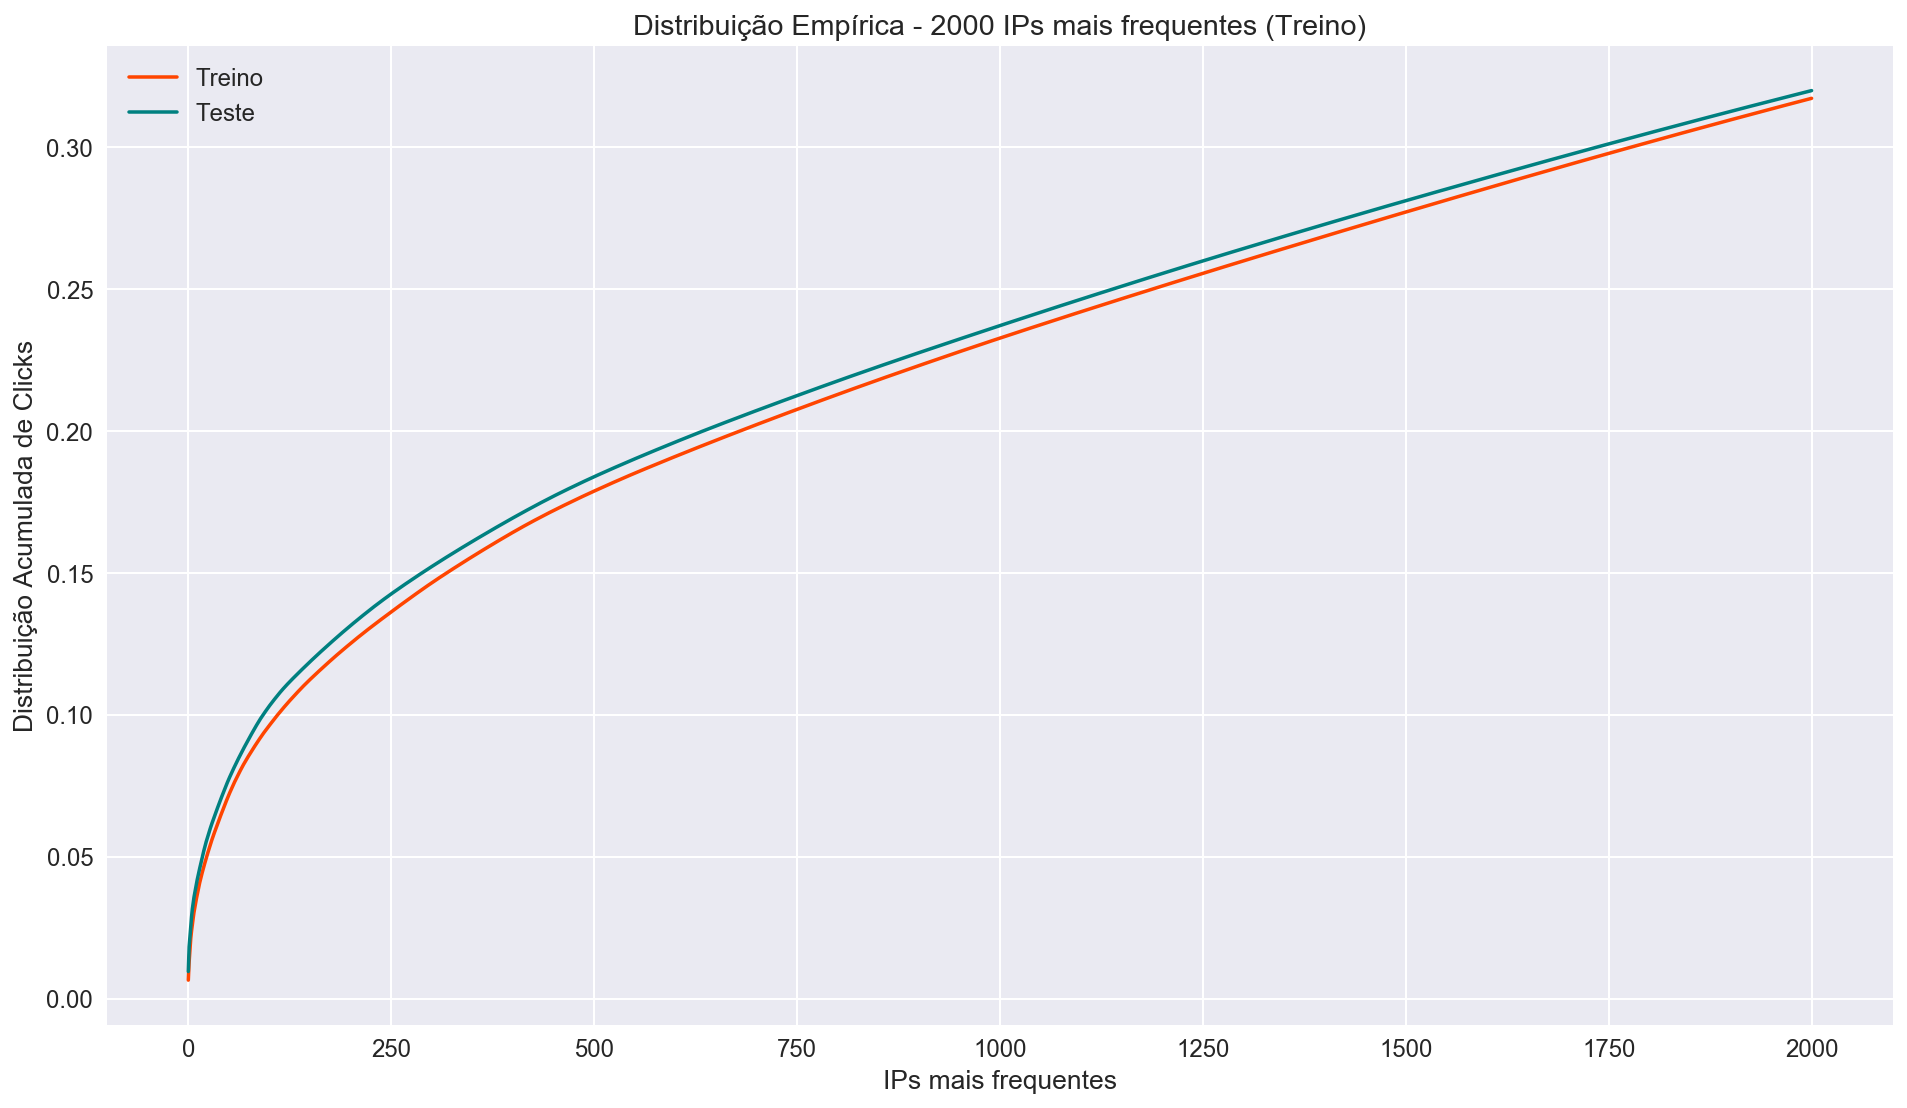

In [28]:
merge['cumulative'] = merge.clicks.cumsum()/train.ip.count()

limit = 2000
plt.figure(figsize = (16,9))
plt.plot(merge.cumulative[:limit], color = 'orangered', label = 'Treino')
plt.xlabel('IPs mais frequentes')
plt.ylabel('Distribuição Acumulada de Clicks')
plt.title('Distribuição Empírica - ' + str(limit) + ' IPs mais frequentes (Treino)')

total = test.ip.count()
m = test.ip.value_counts().reset_index()['ip'].cumsum()/total
plt.plot(m[:limit], color = 'teal', label = 'Teste')

plt.legend()
plt.show()

Plotamos a distribuição acumulada empírica de clicks. No eixo X, temos uma ordenação dos IPs mais frequentes. Podemos observar que os 100 ips mais frequentes nos dados de Treinamento representam quase 10% dos clicks totais, o que também ocorre no caso dos dados de Teste. Se olharmos para os 2000 IPs mais frequentes, este número sobe para mais de 30%. Parece ser o caso em que devêssemos implementar, num modelo preditivo, algum tipo de *blacklist* por ip.

A distribuição empírica dos dados de Treino se coloca consistentemente abaixo da distribuição de Teste. Isto implica que a característica de ter poucos IPs representando larga parcela dos clicks totais é mais exacerbada no caso dos dados de Teste.

### Outras *features*
Analisamos a seguir as features *os*, *app*, *device* e *channel* buscando da mesma maneira algum tipo de relação entre a taxa de conversão e o número de clicks.

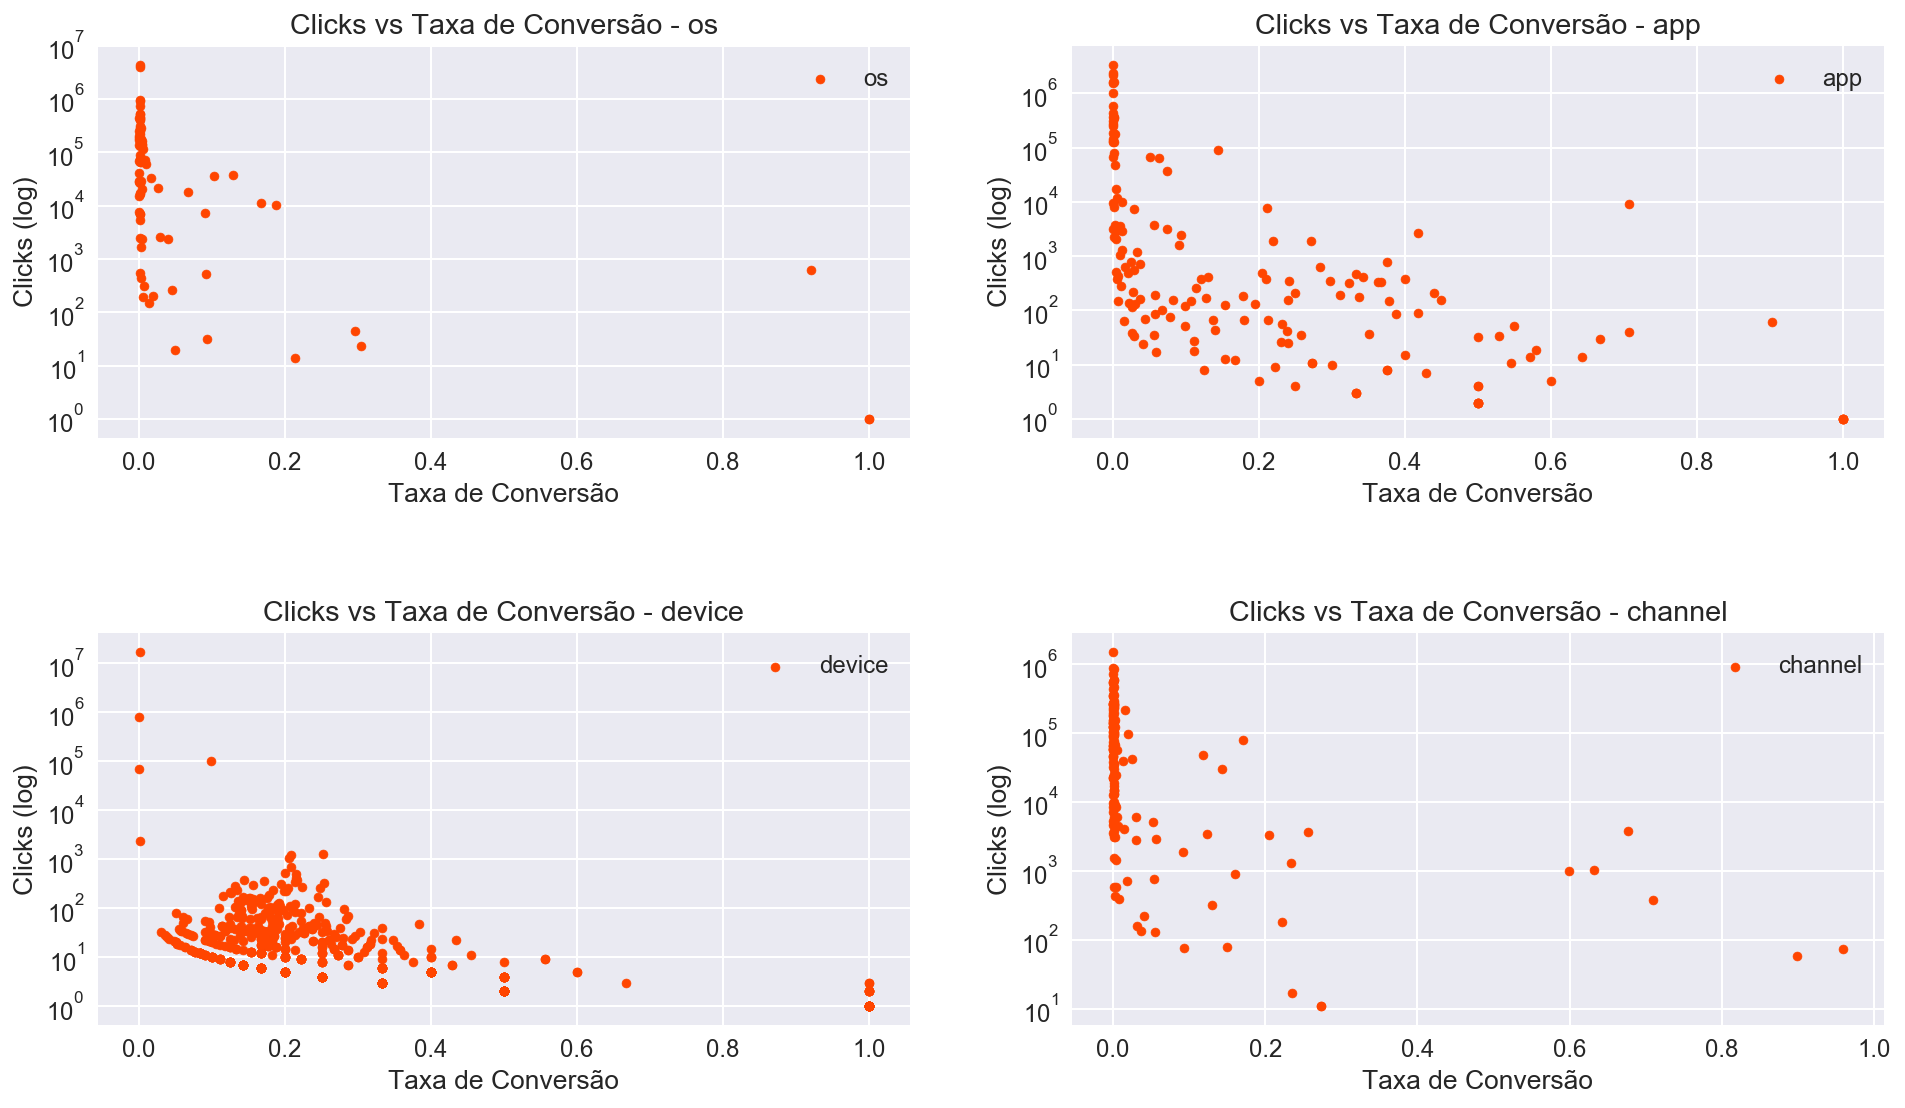

In [29]:
features = ['os', 'app', 'device', 'channel']
fig, axs = plt.subplots(2,2, figsize = (16,9))
tuples = [(0,0), (0,1), (1,0), (1,1)]
plt.subplots_adjust(hspace = 0.5)

for idx, f in enumerate(features):
    proportion = train[[f, 'is_attributed']].groupby(f, as_index=False).mean().sort_values('is_attributed', 
                                                                                             ascending=False)
    counts = train[[f, 'is_attributed']].groupby(f, as_index=False).count().sort_values('is_attributed', 
                                                                                          ascending=False)
    merge = counts.merge(proportion, on= f , how='left')
    merge.columns = [f , 'clicks', 'prop']
    merge[merge.prop > 0].plot(kind = 'scatter', x = 'prop', y = 'clicks', color = 'orangered', 
                        logy = True, ax = axs[tuples[idx]], label = f, legend = True)
    axs[tuples[idx]].set_ylabel('Clicks (log)');
    axs[tuples[idx]].set_xlabel('Taxa de Conversão');
    axs[tuples[idx]].set_title('Clicks vs Taxa de Conversão - ' + str(f))
    
gc.collect();

Qualitativamente, observamos o mesmo comportamento destas features com relação à dinâmica de clicks e taxa de conversão. Há uma relação inversa entre gerar muitos clicks e transformar clicks em downloads. Esta tendência é menos pronunciada em *device*, contudo. Este resultado persiste ainda que consideremos somente os casos em que determinada categoria de uma feature gera ao menos algum download.

Em conjunto com a dinâmica já observada dos IPs, este tipo de relação aponta para a possibilidade de uma estratégia preditiva baseada em *blacklists* ser bem sucedida.

### Clusters
Finalmente, julgamos que seria interessante aplicar alguma técnica de clusterização. Ocorre que os dados em questão são categóricos. Isto inviabiliza a utilização de um algoritmo de *Unsupervised Machine Learning* como o K-means, por exemplo. Tentamos implementar o K-modes, algoritmo bem adaptado ao uso de dados categóricos, através do pacote [```kmodes```](https://github.com/nicodv/kmodes) mas não obtivemos sucesso. O algoritmo parece computacionalmente custoso e não conseguimos aplicá-lo sobre os 10% de dados de Treino com os quais trabalhamos, nem mesmo quando tentamos utilizar servidores de pesquisa da EMAp e da EPGE.

Recorremos a uma solução menos sofisticada mas também efetiva: construir clusters manualmente, através de quartis do número de clicks.

In [30]:
# Colocando no dtFrame de teste a coluna de contagem de clicks também
temp = test['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
test = test.merge(temp, on='ip', how='left')

temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
train = train.merge(temp, on='ip', how='left')

In [31]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,counts
0,103022,3,1,23,379,0,6,14,37,44,571
1,114221,3,1,19,379,0,6,14,37,59,175
2,47902,3,1,17,379,0,6,14,48,7,551
3,23550,3,1,13,379,0,6,14,53,39,328
4,84644,3,1,19,379,0,6,14,56,49,6326


In [32]:
# Usando a contagem de clicks para classificar as linhas dos dtFrames
categories = ['low click', 'med I click', 'med II click', 'high click']

test['click_class'] = pd.qcut(test['counts'], 4, categories)
train['click_class'] = pd.qcut(train['counts'], 4, categories)

In [33]:
classes = ['low click', 'med I click', 'med II click', 'high click']
dataframes = [train, test]
cols = ['ip', 'app', 'device', 'os', 'channel']

resume_train = {}
resume_test = {}

# Coletando qtos registros únicos existem em cada feature
# Dados de treino
for cl in classes:
    x = {}
    for col in cols:
        temp = train[train['click_class']==cl]
        x['{}'.format(col)] = len(temp[col].unique())
        
    resume_train['{}'.format(cl)] = x

# Dados de teste
for cl in classes:
    x = {}
    for col in cols:
        temp = test[test['click_class']==cl]
        x['{}'.format(col)] = len(temp[col].unique())
        
    resume_test['{}'.format(cl)] = x

# Reordenando as colunas do dataframe
resume_train = pd.DataFrame(resume_train)
resume_test = pd.DataFrame(resume_test)
resume_train = resume_train[['low click', 'med I click', 'med II click', 'high click']]
resume_test = resume_test[['low click', 'med I click', 'med II click', 'high click']]
resume_train.head()

,low click,med I click,med II click,high click
app,383,340,344,365
channel,180,174,172,176
device,1070,706,764,924
ip,158178,12051,4484,1187
os,259,233,241,294


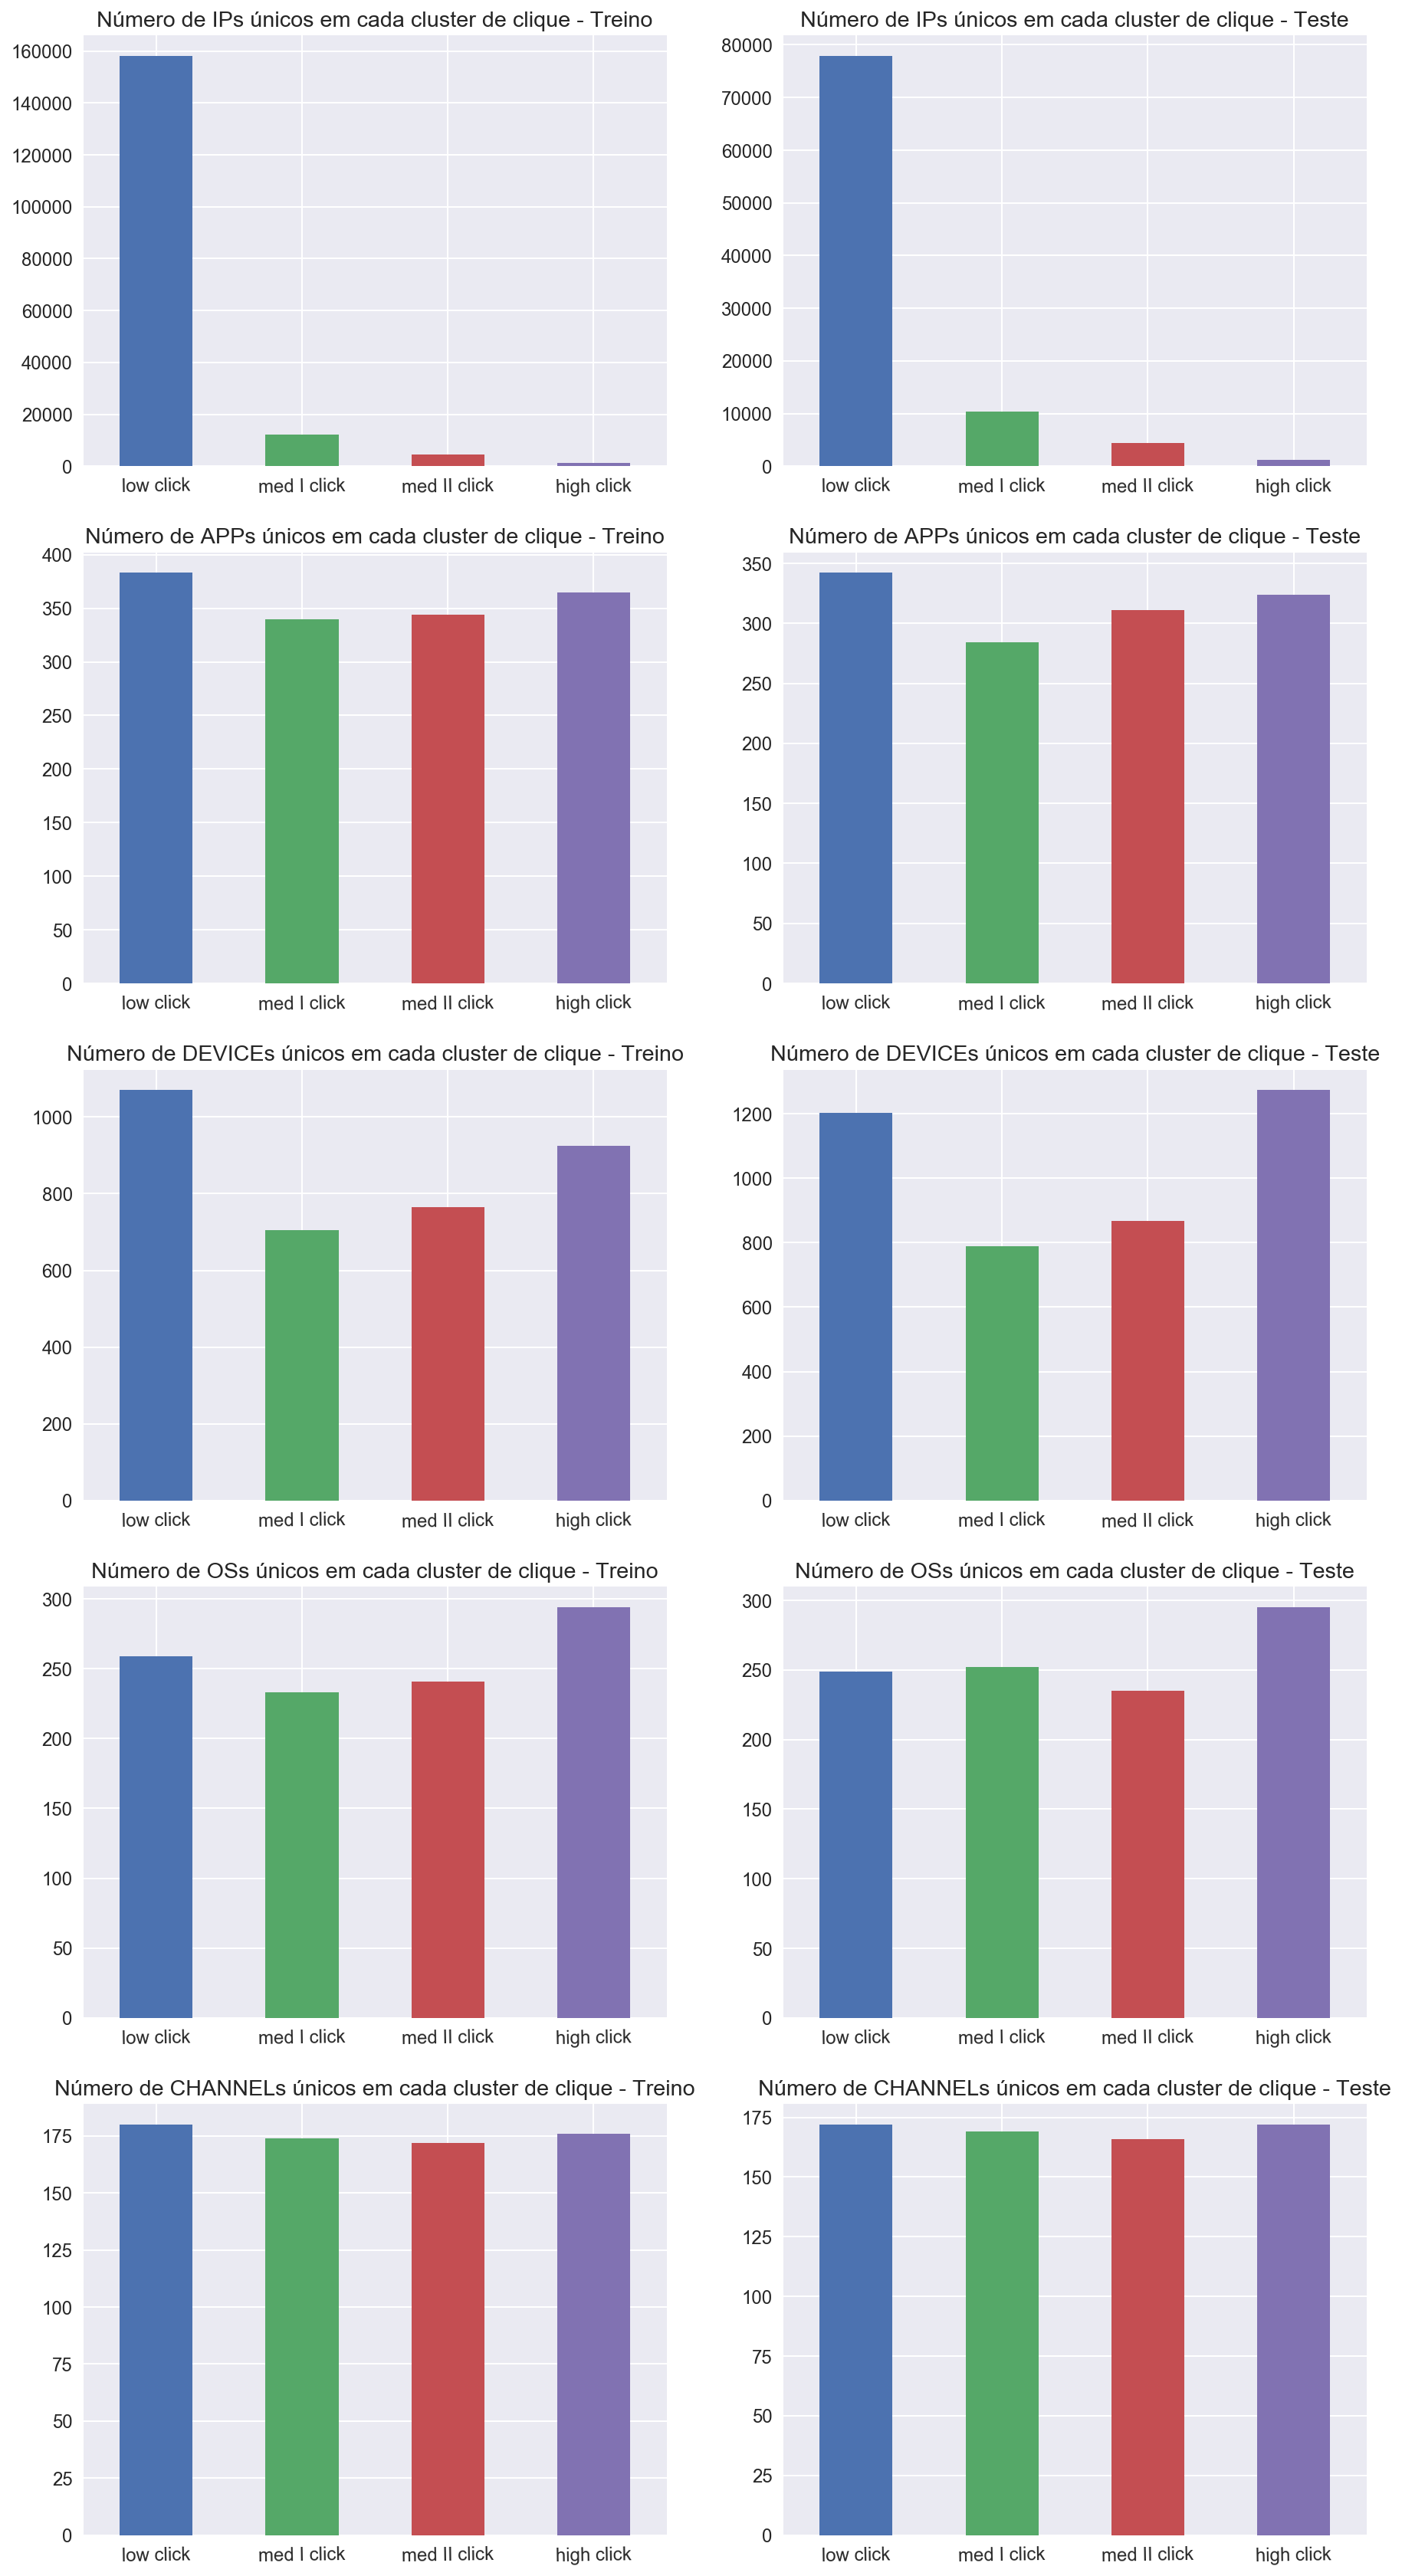

In [34]:
# Fazendo o plot dos dados únicos

fig, axs = plt.subplots(5, 2, figsize=(15,30))
dataframes = [resume_train, resume_test]
sns.set(font_scale=1.2)


for n, df in enumerate(dataframes):
    for i, col in enumerate(cols):
        df.loc[col, :].plot(kind= 'bar', ax=axs[i, n], 
                     title= 'Número de {0}s únicos em cada cluster de clique - {1}'.format(col.upper(),
                                                                                    'Treino' if n==0 else 'Teste'))
        axs[i, n].tick_params(axis= 'x', labelrotation= 1)   

Dividimos os IPs em quatro grupos, de acordo com o número de clicks que geraram. Para cada grupo e cada feature, contabilizamos o número de elementos únicos. Como esperado, há muitos IPs com poucos clicks e alguns poucos IPs figurando no grupo *high click*. 

Entretanto, não observamos nenhum tipo de comportamento pronunciado com respeito às outras *features*. Os elementos únicos estão em número comparáveis entre os grupos para todas *features* analisadas.